In [43]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
data = pd.read_csv('heart_disease_dataset.csv', sep =';')
df=data.copy()

In [45]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [46]:
df.shape

(303, 14)

In [47]:
df.describe()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      303 non-null    int64  
 1   sex                      303 non-null    int64  
 2   chest_pain_type          303 non-null    int64  
 3   resting_blood_pressure   303 non-null    int64  
 4   cholesterol              303 non-null    int64  
 5   fasting_blood_sugar      303 non-null    int64  
 6   rest_ecg                 303 non-null    int64  
 7   max_heart_rate_achieved  303 non-null    int64  
 8   exercise_induced_angina  303 non-null    int64  
 9   st_depression            303 non-null    float64
 10  st_slope                 303 non-null    int64  
 11  num_major_vessels        303 non-null    int64  
 12  thalassemia              303 non-null    int64  
 13  target                   303 non-null    int64  
dtypes: float64(1), int64(13)
m

In [49]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [50]:
X = df.drop('target', axis=1)
y= df['target'].values.reshape(-1, 1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=3)

In [52]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
class MLP():  
    def __init__(self, layers=[13,6,4,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        np.random.seed(1) 
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
        self.params['W3'] = np.random.randn(self.layers[2],self.layers[3]) 
        self.params['b3'] = np.random.randn(self.layers[3],)

    
    def relu(self,Z):
        return np.maximum(0,Z)

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eta(self, x):
      ETA = 0.0000000001
      return np.maximum(x, ETA)


    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.eta(yhat) ## clips value to avoid NaNs in log
        yhat_inv = self.eta(yhat_inv) 
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return loss

    def forward_propagation(self):
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = self.relu(Z2)
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        
        yhat = self.sigmoid(Z3)
        loss = self.entropy_loss(self.y,yhat)

            
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['Z3'] = Z3
        self.params['A1'] = A1
        self.params['A2'] = A2

        return yhat,loss

    def back_propagation(self,yhat):
 
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z3 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A2 = dl_wrt_z3.dot(self.params['W3'].T)
        dl_wrt_w3 = self.params['A2'].T.dot(dl_wrt_z3)
        dl_wrt_b3 = np.sum(dl_wrt_z3, axis=0, keepdims=True)
        
        dl_wrt_z2 = dl_wrt_A2 * self.dRelu(self.params['Z2'])
        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #updating the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.init_weights() #initialize


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)

    def predict(self, X):

        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = self.relu(Z2)
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        pred = self.sigmoid(Z3)
        return np.round(pred) 


    def acc(self, y, yhat):

        acc = float(sum(y == yhat) / len(y))
        return acc


    def plot_loss(self):
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()

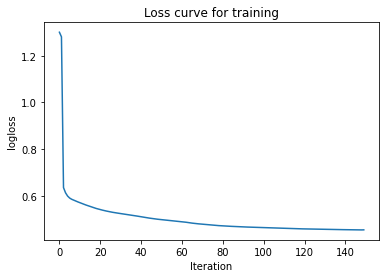

In [54]:
mlp = MLP(layers=[13,6,4,1], learning_rate=0.01, iterations=150) 
mlp.fit(X_train, y_train) 
mlp.plot_loss()

In [55]:
train_pred = mlp.predict(X_train)
test_pred = mlp.predict(X_test)

print("Train accuracy is {:.6f}".format(mlp.acc(y_train, train_pred)))
print("Test accuracy is {:.6f}".format(mlp.acc(y_test, test_pred)))

Train accuracy is 0.853774
Test accuracy is 0.802198


In [56]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        97
           1       0.90      0.83      0.86       115

    accuracy                           0.85       212
   macro avg       0.85      0.86      0.85       212
weighted avg       0.86      0.85      0.85       212



In [57]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        41
           1       0.85      0.78      0.81        50

    accuracy                           0.80        91
   macro avg       0.80      0.80      0.80        91
weighted avg       0.81      0.80      0.80        91

